In [1]:
import ROOT
from ROOT import TMVA

Welcome to JupyROOT 6.22/08


## Declare factory 

In [2]:
ROOT.TMVA.Tools.Instance()
## For PYMVA methods
TMVA.PyMethodBase.PyInitialize();


outputFile = ROOT.TFile.Open("ClassificationOutput.root", "RECREATE")

factory = ROOT.TMVA.Factory("TMVA_Classification", outputFile,
                      "!V:ROC:!Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

## Input data

In [3]:
data_input = "data_ntuple.root"
MC_input = "MC_ntuple.root"

data_file = ROOT.TFile.Open(data_input)
MC_file = ROOT.TFile.Open(MC_input)
# retrieve input trees

signalTree     = MC_file.Get("ntupleTree")
backgroundTree = data_file.Get("ntupleTree")

signalTree.Print()
# backgroundTree.Print()


******************************************************************************
*Tree    :ntupleTree: ntupleTree                                             *
*Entries :    33027 : Total =        84839065 bytes  File  Size =    8394135 *
*        :          : Tree compression factor =  10.13                       *
******************************************************************************
*Br    0 :hltNames  : vector<string>                                         *
*Entries :    33027 : Total  Size=   60024005 bytes  File Size  =    3025026 *
*Baskets :     1943 : Basket Size=      32000 bytes  Compression=  19.83     *
*............................................................................*
*Br    1 :hltResults : vector<bool>                                          *
*Entries :    33027 : Total  Size=    2851085 bytes  File Size  =     342595 *
*Baskets :       94 : Basket Size=      32000 bytes  Compression=   8.32     *
*...................................................

In [4]:
loader = ROOT.TMVA.DataLoader("dataset")

### global event weights per tree (see below for setting event-wise weights)
signalWeight     = 1.0
backgroundWeight = 1.0
   
### You can add an arbitrary number of signal or background trees
loader.AddSignalTree    ( signalTree,     signalWeight     )
loader.AddBackgroundTree( backgroundTree, backgroundWeight )

## Define input variables 

loader.AddVariable("Dimuon_CL")
loader.AddVariable("Dimuon_LS")
loader.AddVariable("Dimuon_CosAlpha")
loader.AddVariable("B_Eta")
loader.AddVariable("Bz_LS")
loader.AddVariable("Bz_CL")
loader.AddVariable("Bz_CosAlpha")
loader.AddVariable("Kstar_Mass")
loader.AddVariable("track1_pT")
loader.AddVariable("track1_eta")
loader.AddVariable("track1_d0")
loader.AddVariable("track2_pT")
loader.AddVariable("track2_eta")
loader.AddVariable("track2_d0")
loader.AddVariable("Muon1_pT")
loader.AddVariable("Muon1_eta")
loader.AddVariable("Muon2_pT")
loader.AddVariable("Muon2_eta")

DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree ntupleTree of type Signal with 33027 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree ntupleTree of type Background with 943 events


## Optimize the background data:
Filter the events from the data that are from the signal peak region, so that we are sure to only feed pure background to the NN (avoid giving it few signal events in the data)

 FCN=3912.65 FROM MIGRAD    STATUS=CONVERGED     123 CALLS         124 TOTAL
                     EDM=1.52871e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.57220e+03   3.83931e+01   8.19210e-01   7.95080e-07
   2  Mean         5.27325e+00   2.68959e-04   7.72462e-06  -1.48288e-01
   3  Sigma        4.31131e-02   2.58953e-04   2.35450e-05  -2.31270e-02


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


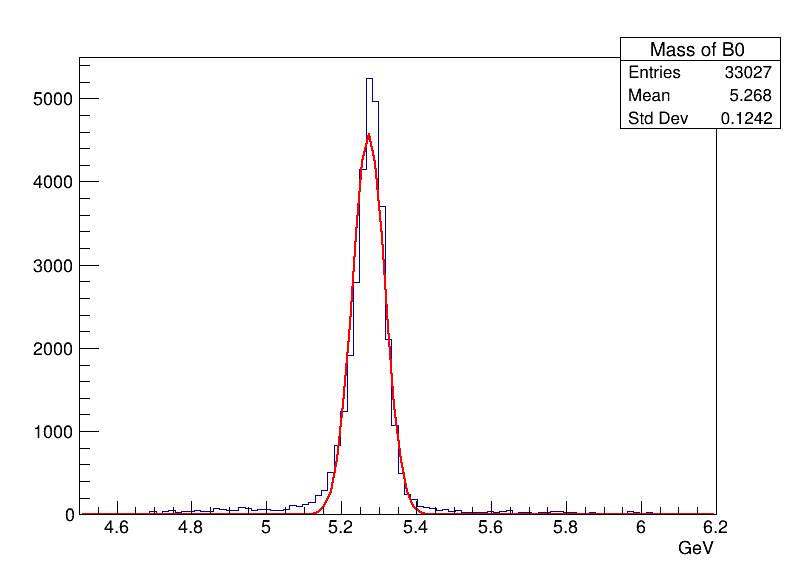

In [5]:
histo_B_mass = ROOT.TH1F("Mass of B0", ";GeV;" , 100, 4.5, 6.2)

for entry in signalTree:
    histo_B_mass.Fill(entry.B_Mass)

histo_B_mass.Fit("gaus")
canvas = ROOT.TCanvas("canvas", "Title", 800, 600)
histo_B_mass.Draw()
canvas.Draw()

## Check the cut 

The range for the peak to discriminate the signal from the background is between 5.230137 and 5.316363


Warning in <TFile::Append>: Replacing existing TH1: Mass of B0 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


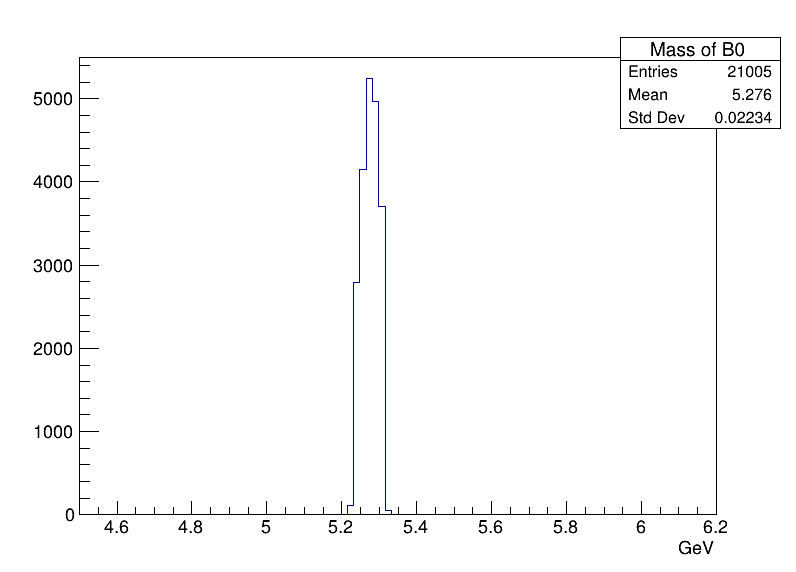

In [6]:
sigma = 4.31131e-02
mean = 5.27325e+00
range1 = mean-sigma
range2 = mean+sigma
histo_B = ROOT.TH1F("Mass of B0", ";GeV;" , 100, 4.5, 6.2)

for entry in signalTree:
    if (entry.B_Mass < range2 and entry.B_Mass > range1):
        histo_B.Fill(entry.B_Mass)

canvas = ROOT.TCanvas("canvas", "Title", 800, 600)
histo_B.Draw()
canvas.Draw()
print ("The range for the peak to discriminate the signal from the background is between %f and %f"%(range1,range2))

## Apply the filter 

Number of entries for signal & background: 33027 & 943
Number of signal events for training: 16514
Number of background events for training: 472


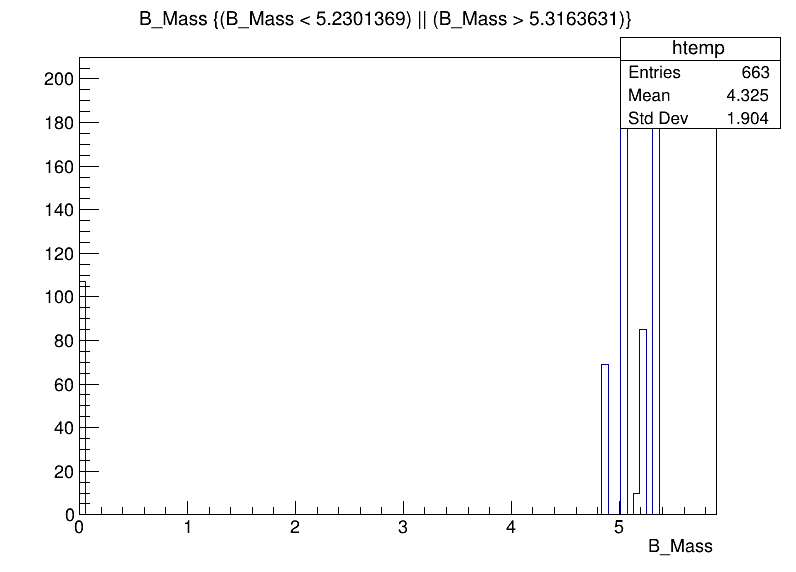

In [7]:
## Apply additional cuts on the signal and background samples (can be different)
mycuts = ROOT.TCut("")  
mycutb = ROOT.TCut("(B_Mass < 5.2301369) || (B_Mass > 5.3163631)")   ## cut events from the signal region
# mycutb = ROOT.TCut("")

# Check number of events left after the cut 
canvas2 = ROOT.TCanvas("canvas2", "Title", 800, 600)
backgroundTree.Draw("B_Mass", mycutb)
canvas2.Draw()


# Check number of events 
sig_num = signalTree.GetEntries()
back_num = backgroundTree.GetEntries()
print("Number of entries for signal & background: %d & %d"%(sig_num,back_num))

# Split events for training and testing
if (sig_num%2==0):
    sig_train = sig_num/2
else: 
    sig_train = (sig_num/2)+0.5
    
if (back_num%2==0):
    back_train = back_num/2
else: 
    back_train = (back_num/2)+0.5
    
print("Number of signal events for training: %d"%sig_train)
print("Number of background events for training: %d"%back_train)

loader.PrepareTrainingAndTestTree(mycuts, mycutb,
                                  "nTrain_Signal=%d:nTrain_Background=%d:SplitMode=Random:"
                                  "NormMode=NumEvents:!V"%(sig_train,back_train))

## Booking

In [8]:
## Boosted Decision Trees
factory.BookMethod(loader,ROOT.TMVA.Types.kBDT, "BDT",
                   "!V:NTrees=200:MinNodeSize=2.5%:MaxDepth=2:BoostType=AdaBoost:AdaBoostBeta=0.5:UseBaggedBoost:"
                   "BaggedSampleFraction=0.5:SeparationType=GiniIndex:nCuts=20" )

## Multi-Layer Perceptron (Neural Network)
factory.BookMethod(loader, ROOT.TMVA.Types.kMLP, "MLP",
                   "!H:!V:NeuronType=tanh:VarTransform=N:NCycles=100:HiddenLayers=N+5:TestRate=5:!UseRegulator" );

Factory                  : Booking method: BDT
                         : 
                         : Building event vectors for type 2 Signal
                         : Dataset[dataset] :  create input formulas for tree ntupleTree
                         : Building event vectors for type 2 Background
                         : Dataset[dataset] :  create input formulas for tree ntupleTree
DataSetFactory           : [dataset] : Number of events in input trees
                         : Dataset[dataset] :     Signal     requirement: ""
                         : Dataset[dataset] :     Signal          -- number of events passed: 33027  / sum of weights: 33027
                         : Dataset[dataset] :     Signal          -- efficiency             : 1     
                         : Dataset[dataset] :     Background requirement: "(B_Mass < 5.2301369) || (B_Mass > 5.3163631)"
                         : Dataset[dataset] :     Background      -- number of events passed: 663    / sum of we

## Training 

In [9]:
factory.TrainAllMethods();

Factory                  : Train all methods
Factory                  : [dataset] : Create Transformation "I" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'Dimuon_CL' <---> Output : variable 'Dimuon_CL'
                         : Input : variable 'Dimuon_LS' <---> Output : variable 'Dimuon_LS'
                         : Input : variable 'Dimuon_CosAlpha' <---> Output : variable 'Dimuon_CosAlpha'
                         : Input : variable 'B_Eta' <---> Output : variable 'B_Eta'
                         : Input : variable 'Bz_LS' <---> Output : variable 'Bz_LS'
                         : Input : variable 'Bz_CL' <---> Output : variable 'Bz_CL'
                         : Input : variable 'Bz_CosAlpha' <---> Output : variable 'Bz_CosAlpha'
                         : Input : variable 'Kstar_Mass' <---> Output : variable 'Kstar_Mass'
                         : Input : va

## Testing 

In [10]:
factory.TestAllMethods();   

Factory                  : Test all methods
Factory                  : Test method: BDT for Classification performance
                         : 
BDT                      : [dataset] : Evaluation of BDT on testing sample (16704 events)
                         : Elapsed time for evaluation of 16704 events: 0.0559 sec       
Factory                  : Test method: MLP for Classification performance
                         : 
MLP                      : [dataset] : Evaluation of MLP on testing sample (16704 events)
                         : Elapsed time for evaluation of 16704 events: 0.0483 sec       


## Evaluation 

In [11]:
factory.EvaluateAllMethods();

Factory                  : Evaluate all methods
Factory                  : Evaluate classifier: BDT
                         : 
BDT                      : [dataset] : Loop over test events and fill histograms with classifier response...
                         : 
TFHandler_BDT            :        Variable               Mean               RMS       [        Min               Max ]
                         : ----------------------------------------------------------------------------------------------
                         :       Dimuon_CL:          0.52277          0.29464   [        0.0010005          0.99994 ]
                         :       Dimuon_LS:           15.270           20.014   [        0.0091450           249.16 ]
                         : Dimuon_CosAlpha:          0.84024          0.47544   [          -1.0000           1.0000 ]
                         :           B_Eta:        -0.010491           1.2568   [          -2.4299           2.4944 ]
                      

## ROC Curve

In [12]:
%jsroot on
c1 = factory.GetROCCurve(loader);
c1.Draw();
c1.SaveAs("figures/ROC_Curve.pdf")
c1.SaveAs("figures/ROC_Curve.png")

Info in <TCanvas::Print>: pdf file figures/ROC_Curve.pdf has been created
Info in <TCanvas::Print>: png file figures/ROC_Curve.png has been created


In [13]:
outputFile.Close()

## Draw Histograms of classification 

### BDT 

In [14]:
f = ROOT.TFile.Open("ClassificationOutput.root", "READ")
f.ls()

directory = f.Get("dataset/Method_BDT/BDT")
directory.ls()

TFile**		ClassificationOutput.root	
 TFile*		ClassificationOutput.root	
  KEY: TDirectoryFile	dataset;1	dataset
TDirectoryFile*		BDT	BDT
 KEY: TObjString	TrainingPath;1	Collectable string class
 KEY: TObjString	WeightFileName;1	Collectable string class
 KEY: TTree	MonitorNtuple;1	BDT variables
 KEY: TH1D	MVA_BDT_S;1	MVA_BDT_S
 KEY: TH1D	MVA_BDT_B;1	MVA_BDT_B
 KEY: TH1D	MVA_BDT_S_high;1	MVA_BDT_S_high
 KEY: TH1D	MVA_BDT_B_high;1	MVA_BDT_B_high
 KEY: TH1D	MVA_BDT_effS;1	MVA_BDT (signal)
 KEY: TH1D	MVA_BDT_effB;1	MVA_BDT (background)
 KEY: TH1D	MVA_BDT_effBvsS;1	MVA_BDT
 KEY: TH1D	MVA_BDT_rejBvsS;1	MVA_BDT
 KEY: TH1D	MVA_BDT_invBeffvsSeff;1	MVA_BDT
 KEY: TH1D	MVA_BDT_Train_S;1	MVA_BDT_Train_S
 KEY: TH1D	MVA_BDT_Train_B;1	MVA_BDT_Train_B
 KEY: TH1D	MVA_BDT_trainingEffS;1	MVA_BDT (signal)
 KEY: TH1D	MVA_BDT_trainingEffB;1	MVA_BDT (background)
 KEY: TH1D	MVA_BDT_trainingEffBvsS;1	MVA_BDT
 KEY: TH1D	MVA_BDT_trainingRejBvsS;1	MVA_BDT
 KEY: TH1F	Dimuon_CL__Signal;1	Dimuon_CL
 KEY: TH1F	Dimuon_C

In [28]:
# Draw histogram for output variables: classification of events
c = ROOT.TCanvas("c", "Title", 800, 600)
histo_bkg = f.Get("dataset/Method_BDT/BDT/Kstar_Mass__Background")
histo_bkg.SetLineColor(3)
histo_bkg.Draw("")
histo_sig = f.Get("dataset/Method_BDT/BDT/Kstar_Mass__Signal")
histo_sig.Draw("same")
# histo_bkg.SetTitle("BDT Classification of events")
# histo_bkg.SetName("Event Classification")
# histo_sig.SetName("Event Classification")
# histo_bkg.Write("Event Classification",ROOT.TObject.kWriteDelete);
legend = ROOT.TLegend(0.05,0.80,0.2,0.93)
legend.AddEntry(histo_bkg,"Background", "l")
legend.AddEntry(histo_sig,"Signal", "l")
legend.Draw()
c.Draw()
# c.SaveAs("figures/BDT/B_eta.pdf")
c.SaveAs("figures/BDT/Kstar.png")


# Background 
# c1 = ROOT.TCanvas("c1", "Title", 800, 600)
# histo_bkg.Draw()
# c1.Draw()

# # Signal 
# histo_sig.Draw("same")
# c1.Draw()
# c1.SaveAs("figures/BDT/B_Eta.pdf")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file figures/BDT/Kstar.png has been created


In [29]:
directory2 = f.Get("dataset/Method_BDT/BDT/CorrelationPlots")
directory2.ls()
# Draw histogram for output variables: classification of events
c = ROOT.TCanvas("c", "Title", 800, 600)
histo_bkg = f.Get("dataset/Method_BDT/BDT/CorrelationPlots/scat_Dimuon_LS_vs_Dimuon_CL_Signal")
# histo_bkg.SetLineColor(3)
histo_bkg.Draw("")
# histo_sig = f.Get("dataset/Method_BDT/BDT/Kstar_Mass__Signal")
# histo_sig.Draw("same")
# histo_bkg.SetTitle("BDT Classification of events")
# histo_bkg.SetName("Event Classification")
# histo_sig.SetName("Event Classification")
# histo_bkg.Write("Event Classification",ROOT.TObject.kWriteDelete);
# legend = ROOT.TLegend(0.05,0.80,0.2,0.93)
# legend.AddEntry(histo_bkg,"Background", "l")
# legend.AddEntry(histo_sig,"Signal", "l")
# legend.Draw()
c.Draw()
# c.SaveAs("figures/BDT/B_eta.pdf")
c.SaveAs("figures/BDT/correlation.png")

TDirectoryFile*		CorrelationPlots	CorrelationPlots
 KEY: TH2F	scat_Dimuon_LS_vs_Dimuon_CL_Signal;1	Dimuon_LS versus Dimuon_CL (Signal)
 KEY: TProfile	prof_Dimuon_LS_vs_Dimuon_CL_Signal;1	profile Dimuon_LS versus Dimuon_CL (Signal)
 KEY: TH2F	scat_Dimuon_LS_vs_Dimuon_CL_Background;1	Dimuon_LS versus Dimuon_CL (Background)
 KEY: TProfile	prof_Dimuon_LS_vs_Dimuon_CL_Background;1	profile Dimuon_LS versus Dimuon_CL (Background)
 KEY: TH2F	scat_Dimuon_CosAlpha_vs_Dimuon_CL_Signal;1	Dimuon_CosAlpha versus Dimuon_CL (Signal)
 KEY: TProfile	prof_Dimuon_CosAlpha_vs_Dimuon_CL_Signal;1	profile Dimuon_CosAlpha versus Dimuon_CL (Signal)
 KEY: TH2F	scat_Dimuon_CosAlpha_vs_Dimuon_CL_Background;1	Dimuon_CosAlpha versus Dimuon_CL (Background)
 KEY: TProfile	prof_Dimuon_CosAlpha_vs_Dimuon_CL_Background;1	profile Dimuon_CosAlpha versus Dimuon_CL (Background)
 KEY: TH2F	scat_B_Eta_vs_Dimuon_CL_Signal;1	B_Eta versus Dimuon_CL (Signal)
 KEY: TProfile	prof_B_Eta_vs_Dimuon_CL_Signal;1	profile B_Eta versus Dimu

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file figures/BDT/correlation.png has been created


In [16]:
c3 = ROOT.TCanvas("c3", "Title", 800, 600)
histo_eff_B = f.Get("dataset/Method_BDT/BDT/MVA_BDT_effB")
histo_eff_S = f.Get("dataset/Method_BDT/BDT/MVA_BDT_effS")
# histoKstar_B.Draw()
histo_eff_B.Draw("")
c3.Draw()
c3.SaveAs("figures/BDT/efficiencyS.pdf")

Info in <TCanvas::Print>: pdf file figures/BDT/efficiencyS.pdf has been created


In [17]:
c4 = ROOT.TCanvas("c4", "Title", 800, 600)
histo_eff_B = f.Get("dataset/Method_BDT/BDT/MVA_BDT_effB")
histo_eff_S = f.Get("dataset/Method_BDT/BDT/MVA_BDT_effS")
# histoKstar_B.Draw()
histo_eff_B.Draw("")
c3.Draw()
c3.SaveAs("figures/BDT/efficiencyS.pdf")

Info in <TCanvas::Print>: pdf file figures/BDT/efficiencyS.pdf has been created


### MLP

In [18]:
f2 = ROOT.TFile.Open("ClassificationOutput.root", "READ")
f2.ls()

directory = f2.Get("dataset/Method_MLP/MLP")
directory.ls()

TFile**		ClassificationOutput.root	
 TFile*		ClassificationOutput.root	
  KEY: TDirectoryFile	dataset;1	dataset
TDirectoryFile*		MLP	MLP
 KEY: TObjString	TrainingPath;1	Collectable string class
 KEY: TObjString	WeightFileName;1	Collectable string class
 KEY: TH1F	estimatorHistTrain;1	training estimator
 KEY: TH1F	estimatorHistTest;1	test estimator
 KEY: TH2F	weights_hist01;1	weights_hist01
 KEY: TH2F	weights_hist12;1	weights_hist12
 KEY: TDirectoryFile	EpochMonitoring;1	EpochMonitoring
 KEY: TH1D	MVA_MLP_S;1	MVA_MLP_S
 KEY: TH1D	MVA_MLP_B;1	MVA_MLP_B
 KEY: TH1D	MVA_MLP_S_high;1	MVA_MLP_S_high
 KEY: TH1D	MVA_MLP_B_high;1	MVA_MLP_B_high
 KEY: TH1D	MVA_MLP_effS;1	MVA_MLP (signal)
 KEY: TH1D	MVA_MLP_effB;1	MVA_MLP (background)
 KEY: TH1D	MVA_MLP_effBvsS;1	MVA_MLP
 KEY: TH1D	MVA_MLP_rejBvsS;1	MVA_MLP
 KEY: TH1D	MVA_MLP_invBeffvsSeff;1	MVA_MLP
 KEY: TH1D	MVA_MLP_Train_S;1	MVA_MLP_Train_S
 KEY: TH1D	MVA_MLP_Train_B;1	MVA_MLP_Train_B
 KEY: TH1D	MVA_MLP_trainingEffS;1	MVA_MLP (signal)
 KEY: TH1

In [19]:
# Draw histogram for output variables: classification of events
c4 = ROOT.TCanvas("c4", "Title", 800, 600)
h_bkg = f2.Get("dataset/Method_MLP/MLP/MVA_MLP_B")
h_bkg.SetLineColor(3)
h_bkg.Draw("")
h_sig = f2.Get("dataset/Method_MLP/MLP/MVA_MLP_S")
h_sig.Draw("same")
h_bkg.SetTitle("MLP Classification of events")
h_bkg.SetName("Event Classification")
h_sig.SetName("Event Classification")
h_bkg.Write("Event Classification", ROOT.TObject.kWriteDelete);
legend = ROOT.TLegend(0.05,0.80,0.2,0.93)
legend.AddEntry(h_bkg,"Background", "l")
legend.AddEntry(h_sig,"Signal", "l")
legend.Draw()
c4.Draw()
c4.SaveAs("figures/MLP/MVA_MLP.pdf")
c4.SaveAs("figures/MLP/MVA_MLP.png")

# Background 
c5 = ROOT.TCanvas("c5", "Title", 800, 600)
h_bkg.Draw()
c5.Draw()
c5.SaveAs("figures/MLP/MVA_MLP_B.pdf")

# Signal 
c6 = ROOT.TCanvas("c6", "Title", 800, 600)
h_sig.Draw()
c6.Draw()
c6.SaveAs("figures/MLP/MVA_MLP_S.pdf")

c7 = ROOT.TCanvas("c7", "Title", 800, 600)
histo_bkg = f2.Get("dataset/Method_MLP/MLP/MVA_MLP_B")
histo_bkg.SetLineColor(3)
histo_bkg.Draw("")
histo_sig = f2.Get("dataset/Method_MLP/MLP/MVA_MLP_S")
histo_sig.Draw("same")
# histo_bkg.SetTitle("MLP Classification of events")
# histo_bkg.SetName("Event Classification")
# histo_sig.SetName("Event Classification")
histo_bkg.Write("Event Classification", ROOT.TObject.kWriteDelete);
legend = ROOT.TLegend(0.05,0.80,0.2,0.93)
legend.AddEntry(h_bkg,"Background", "l")
legend.AddEntry(h_sig,"Signal", "l")
legend.Draw()
c4.Draw()
c4.SaveAs("figures/MLP/MVA_MLP.pdf")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c4
Error in <TFile::WriteTObject>: Directory ClassificationOutput.root is not writable
Info in <TCanvas::Print>: pdf file figures/MLP/MVA_MLP.pdf has been created
Info in <TCanvas::Print>: png file figures/MLP/MVA_MLP.png has been created
Info in <TCanvas::Print>: pdf file figures/MLP/MVA_MLP_B.pdf has been created
Info in <TCanvas::Print>: pdf file figures/MLP/MVA_MLP_S.pdf has been created
Error in <TFile::WriteTObject>: Directory ClassificationOutput.root is not writable
Info in <TCanvas::Print>: pdf file figures/MLP/MVA_MLP.pdf has been created
